# Search Paths

In the last reading, we learned about how to check whether there is a path from node A to node B.

In this reading, we'll do additional things:

1. return the path (a list of nodes) found instead of just True/False
2. learn BFS, an alternative to DFS that is guaranteed to find the shortest path

In [1]:
from graphviz import Graph, Digraph

## Review

Let's revisit the graph search from the end of the last reading (only change is addition of `__repr__`):

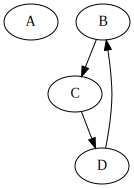

In [2]:
class mygraph:
    def __init__(self):
        self.nodes = {}
    
    def node(self, name):
        self.nodes[name] = Node(self, name)
    
    def edge(self, src, dst):
        for name in [src, dst]:
            if not name in self.nodes:
                self.node(name)
        self.nodes[src].children.append(self.nodes[dst])
        
    def _repr_svg_(self):
        g = Digraph()
        for n in self.nodes:
            g.node(n)
            for child in self.nodes[n].children:
                g.edge(n, child.name)
        return g._repr_image_svg_xml()
    
    def find(self, src, dst):
        self.visited = set()
        return self.nodes[src].find(dst)

class Node:
    def __init__(self, graph, name):
        self.graph = graph
        self.name = name
        self.children = []
        
    def __repr__(self):
        return "node %s" % self.name
        
    def find(self, dst):
        if self.name in self.graph.visited:
            return False
        self.graph.visited.add(self.name)

        if self.name == dst:
            return True
        for child in self.children:
            if child.find(dst):
                return True
        return False

g = mygraph()
g.node("A")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "B")
g

In [3]:
print(g.find("A", "A"))
print(g.find("A", "B"))
print(g.find("B", "D"))
print(g.find("B", "A"))

True
False
True
False


## Getting the Path

Rather than just determine if there is a path, let's output what it is.  We'll modify the `find` method.  If there's a path, it should return it as a list (or tuple!) of nodes traversed.  If there is not a path, it should return None.

The logic works like this: if the X node is a child of the W node, and we've found an `(X,Y,Z)` path, then `(W,X,Y,Z)` is also a valid path.  On line 11, we're using tuple concatenation to create a new tuple based on the one the child found, but with the parent added to the beginning.

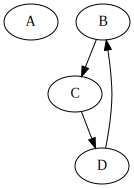

In [4]:
def find_v2(self, dst):
    if self.name in self.graph.visited:
        return None

    if self.name == dst:
        return (self.name, )

    for child in self.children:
        path = child.find(dst)
        if path != None:
            return (self.name, ) + path

    return None

# monkey patching lets us redefine a method in
# a class, without recreating the whole class
# (not a recommended practice, but means we don't
# need to show the complete new version of Node)
Node.find = find_v2

g = mygraph()
g.node("A")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "B")
g

In [5]:
path = g.find("A", "B")
print(path)

None


In [6]:
path = g.find("C", "B")
print(path)

('C', 'D', 'B')


## Multiple Paths

What if there are multiple paths?  Which will we return?

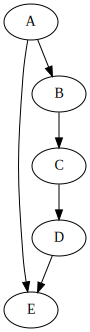

In [7]:
g = mygraph()
g.edge("A", "E")
g.edge("A", "B")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "E")
g

In [8]:
g.find("A", "E")

('A', 'E')

Nice, it found the shortest one!  But what if we build the same graphs, but adding the edges in a different order?

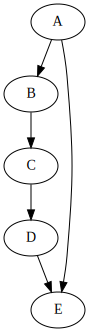

In [9]:
g = mygraph()
g.edge("A", "B")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "E")
g.edge("A", "E") # we used to add this first, now last
g

In [10]:
g.find("A", "E")

('A', 'B', 'C', 'D', 'E')

Yuck!  If Google Maps gave me these directions for getting from city A to E, then I might just switch to Apple Maps.

The search pattern we're using is known as "depth first search", or DFS.  It explores one child completely (including all that child's descendents) before checking if the other children know a path.

The alternative to DFS is BFS, or "breadth first search".  This algorithm will explore all children before exploring grandchildren, before exploring great grandchildren, etc.

The algorithm for BFS is not recursive, but many find it less intuitive that recursive DFS.  The strategy is to keep a "TODO" list of all nodes that need to be visited.  The list is used as a *queue*, meaning the first nodes added to the list will be the first ones visited.  When a child is explored, we generally discover grandchildren, but rather than explore those grandchildren immediately (as in DFS), we add those grandchildren to the end of the TODO queue, to be processed eventually after the other children.

Let's try it:

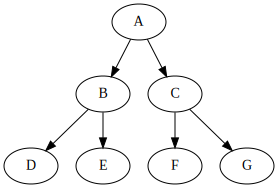

In [11]:
def find_bfs(self, dst):
    # the first node to explore is the starting point
    todo = [self]

    # keep looping while there are unexplored nodes
    while len(todo) > 0:
        print("TODO:", todo)
        curr = todo.pop(0) # pop from beginning

        print("VISITING:", curr)
        if curr.name == dst:
            return True
        else:
            for child in curr.children:
                if not child.name in self.graph.visited:
                    todo.append(child) # add to end
                    self.graph.visited.add(child.name)

    # nothing left to check, and we haven't already returned True
    return False

Node.find = find_bfs

g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g

In [12]:
g.find("A", "G")

TODO: [node A]
VISITING: node A
TODO: [node B, node C]
VISITING: node B
TODO: [node C, node D, node E]
VISITING: node C
TODO: [node D, node E, node F, node G]
VISITING: node D
TODO: [node E, node F, node G]
VISITING: node E
TODO: [node F, node G]
VISITING: node F
TODO: [node G]
VISITING: node G


True

Cool!  We're searching one level at a time.  But did you notice we lost some functionality?  We aren't keeping track of how we got to the final node.  There are often multiple ways to reach a node, so we should add a `back` attribute to backtrack how we got there.

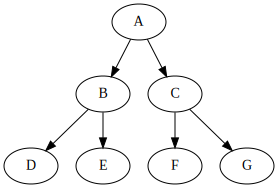

In [13]:
def backtrace(self, node):
    nodes = []
    while node != None:
        nodes.append(node)
        node = node.back
    return tuple(reversed(nodes))

def find_bfs_v2(self, dst):
    # the first node to explore is the starting point
    todo = [self]
    self.back = None
    self.graph.visited.add(self.name)

    # keep looping while there are unexplored nodes
    while len(todo) > 0:
        print("TODO:", todo)
        curr = todo.pop(0) # pop from beginning

        print("VISITING:", curr)
        if curr.name == dst:
            return backtrace(self, curr)
        else:
            for child in curr.children:
                if not child.name in self.graph.visited:
                    todo.append(child)
                    self.graph.visited.add(child.name)

                    # remember we found child via curr
                    # (will help us backtrack later!)
                    child.back = curr
    
    # nothing left to check, and we haven't already returned True
    return None

Node.find = find_bfs_v2

g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g

In [14]:
g.find("A", "G")

TODO: [node A]
VISITING: node A
TODO: [node B, node C]
VISITING: node B
TODO: [node C, node D, node E]
VISITING: node C
TODO: [node D, node E, node F, node G]
VISITING: node D
TODO: [node E, node F, node G]
VISITING: node E
TODO: [node F, node G]
VISITING: node F
TODO: [node G]
VISITING: node G


(node A, node C, node G)

Let's make a tougher test case, with the following:
1. cycles
2. short and long paths to the same target

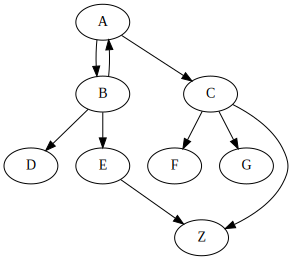

In [15]:
g.edge("E", "Z")
g.edge("C", "Z")
g.edge("B", "A")
g

Now there are two A-to-Z paths:
* A,B,E,Z
* A,C,Z

We ought to find the second one!

In [16]:
g.find("A", "Z")

TODO: [node A]
VISITING: node A
TODO: [node B, node C]
VISITING: node B
TODO: [node C, node D, node E]
VISITING: node C
TODO: [node D, node E, node F, node G, node Z]
VISITING: node D
TODO: [node E, node F, node G, node Z]
VISITING: node E
TODO: [node F, node G, node Z]
VISITING: node F
TODO: [node G, node Z]
VISITING: node G
TODO: [node Z]
VISITING: node Z


(node A, node C, node Z)

Just what we wanted.

# Conclusion



We have lots of experience using data structures like lists and dicts to keep track of data.  But data structures can also be used to keep track work that a program needs to do.  This strategy is used by BFS and many other systems.

Although more complicated to implement, BFS guarantees the shortest path will be found (in contrast to DFS).  Of course, significant memory might be required to maintain the queue of nodes to visit if the graph is large.  Depending on the shape of the graph, this memory expense may be greater or less than the memory needed for the stack frames necessarly during a recursive depth-first search.